# Using Bayes Nets for Automatic Modulation Recognition

### Paul Jojy

The following code is designed to accompany the final paper. Please read the paper first to better understand the experiment. This jupyter notebook requires a tensorflow environment v2.10.0 to run. The code is divided into 5 sections: 

1. **Data Prepocessing:** The dataset is imported and prepared for a machine learning pipeline. This section includes  data visualization as well. 
2. **Design and Train Architecture:** First the Standard CNN is built and trained. The Standard CNN is a simple serial network consisting of a pattern of convolution and max pooling layers. Next the Bayes net is built and trained on the same data. The Bayes net is almost identical to the standard CNN except for the top and bottom layers.
3. **Analyze Results:** I examine and compare the performance of the networks through latency, simple accuracy score, confusion matrix, and a classification report. 
4. **Advantage of Bayes Nets:** This section uses the Bayes net to introduce and illustrate the concept of explainability.
4. **Sources:** This code is inspired by and borrows techniques from the listed sources.

# Install Packages

In [1]:
import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow import keras
from tensorflow import Tensor
print("Tensorflow version is ", tf.__version__)
print('Keras version      : ',keras.__version__)
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import h5py as h5
import time
from sklearn.metrics import classification_report, confusion_matrix
import random
print("Tensorflow Probability version is ", tfp.__version__)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

Tensorflow version is  2.10.0
Keras version      :  2.10.0
Tensorflow Probability version is  0.18.0


# 1. Data Preprocessing

## Import Dataset 

Below I am reading the dataset from DeepSig. This data set contains RF data with 24 different modulations at various SNR. Each of the 2555904 data inputs is 1024 samples long of complex (I Q) data. 3 arrays are created.

myData holds the 1024 I and Q time values for each input sample.

myMods holds the one hot encoded RF class for each sample.

mySNRs holds the SNR value for each sample.

In [2]:
#Note this is needed to aviod a tensorFlow memory issue
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

data_file = '2018.01/GOLD_XYZ_OSC.0001_1024.hdf5'
file_handle = h5.File(data_file,'r+')

myData = file_handle['X'][:]  #1024x2 samples 
myMods = file_handle['Y'][:]  #mods 
mySNRs = file_handle['Z'][:]  #snrs  

print(np.shape(myData))
print(np.shape(myMods))
print(np.shape(mySNRs))
file_handle.close()

np.random.seed(0)

(2555904, 1024, 2)
(2555904, 24)
(2555904, 1)


## List SNRs

Below is the list of Signal to Noise Ratios (SNRs) represented in the data. SNRs measure the amount of "noise" in an image. A lower SNR means the signal is weaker than the noise, and vice versa for a higher SNR. 

In [3]:
snrs = list(np.unique(mySNRs.T[0]))  
print(snrs)

[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]


## Clean the Data

The original dataset contains 24 different classes. I. arbitrarily picked 11 in order to shrink the problem domain, while still processing signals at a variety of modulation schemes (ASK,PSK, QAM, etc.) and varying orders (8, 16, 64)

In [4]:
myData = np.concatenate((myData[212992:745472],myData[851968:958464],myData[1277952:1384448],
                         myData[1490944:1597440],myData[2236416:2555904]),axis=0)
mySNRs = np.concatenate((mySNRs[212992:745472],mySNRs[851968:958464],mySNRs[1277952:1384448],
                         mySNRs[1490944:1597440],mySNRs[2236416:2555904]),axis=0)
myMods = np.concatenate((myMods[212992:745472],myMods[851968:958464],myMods[1277952:1384448],
                         myMods[1490944:1597440],myMods[2236416:2555904]),axis=0)

#re-onehot encode myMods
length = (np.size(myMods, axis=0))
temp = np.concatenate((myMods[:,2:7],myMods[:,8:9],myMods[:,12:13],myMods[:,14:15],myMods[:,21:24]), axis=1)
myMods = temp

mods = [
    '8ASK',      'BPSK',   'QPSK',    '8PSK',
    '16PSK',     '16APSK', '16QAM',   '64QAM',
    'FM',        'GMSK',   'OQPSK']

num_classes = np.shape(mods)[0]
print("The number of classes is ", num_classes)


print(np.shape(myData))
print(np.shape(mySNRs))
print(np.shape(myMods))

print ("Max value of the data set = ", np.max(myData))
print ("Min value of the data set = ", np.min(myData))
print ("Mean value of the data set = ", np.mean(myData))
print ("Standard Deviation of the data set ", np.std(myData) )

The number of classes is  11
(1171456, 1024, 2)
(1171456, 1)
(1171456, 11)
Max value of the data set =  4.599309
Min value of the data set =  -4.7237077
Mean value of the data set =  0.00012607466
Standard Deviation of the data set  0.75386995


## Visualize the Data

Print one example from each class. The orange and blue represent the I&Q channels, respectively.

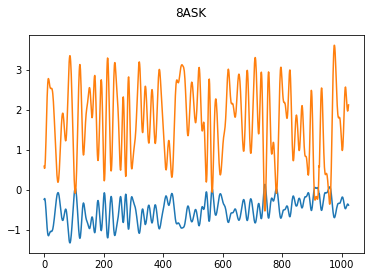

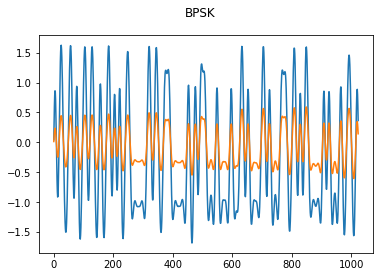

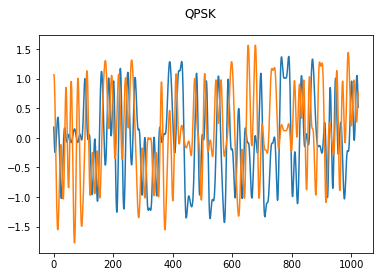

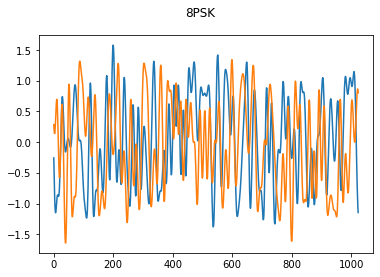

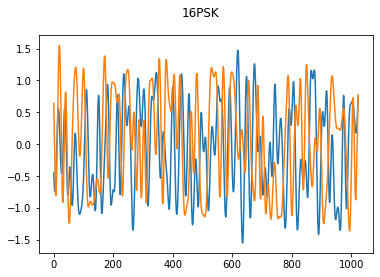

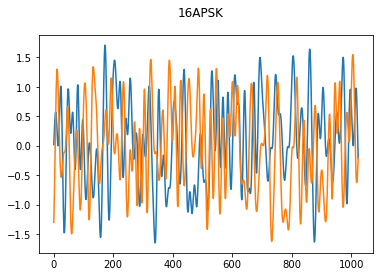

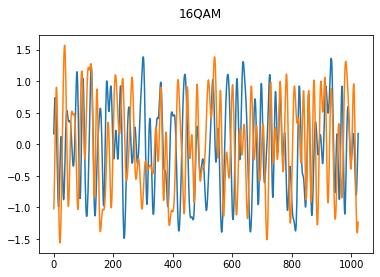

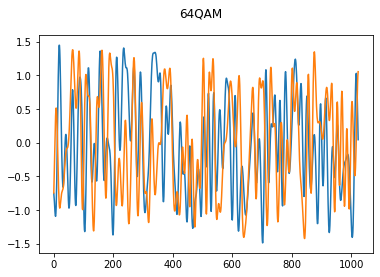

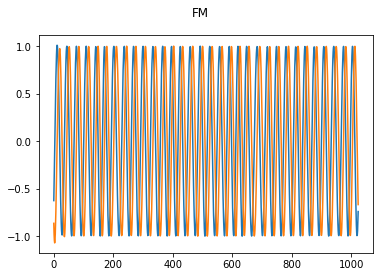

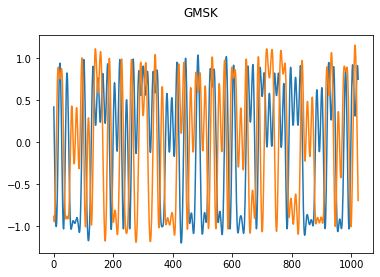

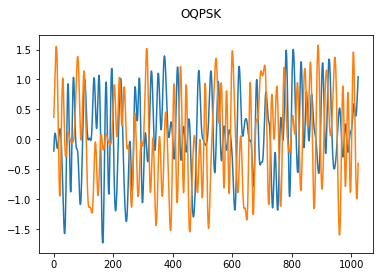

In [5]:
#turn off warning about more than 10 figures plotted
plt.rcParams.update({'figure.max_open_warning': 0})

def my_range(start, end, step):
    while start <= end:
        yield start
        start += step

size = np.size(myData, axis = 0)
step = size//11

for x in my_range(100000, (size-1), step):
    plt.figure()
    plt.suptitle( mods[np.argmax(myMods[x])])
    plt.plot(myData[x,:,0])
    plt.plot(myData[x,:,1])

## Visualize SNR Distribution

By visualizing the distributions of SNRs we can see that the data is evenly distributed across the range of SNRs represented in the set.

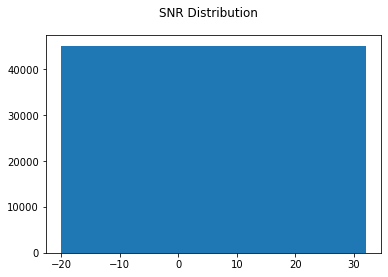

In [6]:
plt.figure()
plt.suptitle("SNR Distribution")
plt.hist(mySNRs, bins = [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]) 
plt.show()

## Split Data into Train and Test

The data is reshaped to have NHWC dimensional ordering (Number of samples, height, width, Number of Channels). It is then split 80%/20% Train/test

In [7]:
myData = myData.reshape(myData.shape[0], 1, 1024, 2) 

In [8]:
X_train ,X_test ,Y_train ,Y_test, Z_train, Z_test =train_test_split(myData, myMods, mySNRs, test_size=0.2, random_state=0)
print (np.shape(X_test))
print (np.shape(Y_test))
print (np.shape(Z_test))
print (np.shape(X_train))
print (np.shape(Y_train))
print (np.shape(Z_train))

(234292, 1, 1024, 2)
(234292, 11)
(234292, 1)
(937164, 1, 1024, 2)
(937164, 11)
(937164, 1)


# 2. Design and Train Architecture

The following architectures were inspired by https://towardsdatascience.com/creating-image-classification-model-with-bayesian-perspective-a90a5956b14e

## Standard CNN

Below I have created a standard CNN. This is a serial CNN that uses a very common pattern of convolutional layers followed by max pooling. The hyperparameters were arbitrarily chosen. The model is then compiled

In [9]:
model = Sequential([
    tf.keras.layers.InputLayer(input_shape=(1, 1024,2)),
    Conv2D(filters=4, kernel_size=(1,25), activation='relu'),
    MaxPool2D(1,2),
    Conv2D(8,kernel_size=(1,5), activation='relu'),
    MaxPool2D(1,2),
    Conv2D(16,kernel_size=(1,5), activation='relu'),
    MaxPool2D(1,2),
    Conv2D(32,kernel_size=(1,5), activation='relu'),
    MaxPool2D(1,2),
    Conv2D(64, (1,5), activation='relu'),
    MaxPool2D(1,2),
    Conv2D(64, (1,5), activation='relu'),
    MaxPool2D(1,4),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(units=11, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 1000, 4)        204       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 500, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 496, 8)         168       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 248, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 244, 16)        656       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 122, 16)       0

In [10]:
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

In [12]:
### Callback. This will end training if validation accuracy does not improve after 5 epochs, to prevent overfitting. 
checkpoint_dir = 'checkpoints'
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

cp_callback = ModelCheckpoint(filepath =checkpoint_dir + '/StandardCNN.h5', 
                              verbose = 1,
                              save_best_only=True, 
                              save_weights_only=False,
                              mode='auto')
earlystopping_callback = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    mode='auto',
    verbose = 1)

## Train Standard CNN

In [13]:
if os.path.exists('checkpoints/StandardCNN.h5'):
    model = load_model('checkpoints/StandardCNN.h5')
else:
    history = model.fit(X_train,
                        Y_train,
                        batch_size=batch_size,
                        epochs=nb_epoch,
                        verbose=1,
                        validation_data=(X_test, Y_test),
                        callbacks = [ cp_callback,earlystopping_callback]
                       )

## Visualize Network Architecture

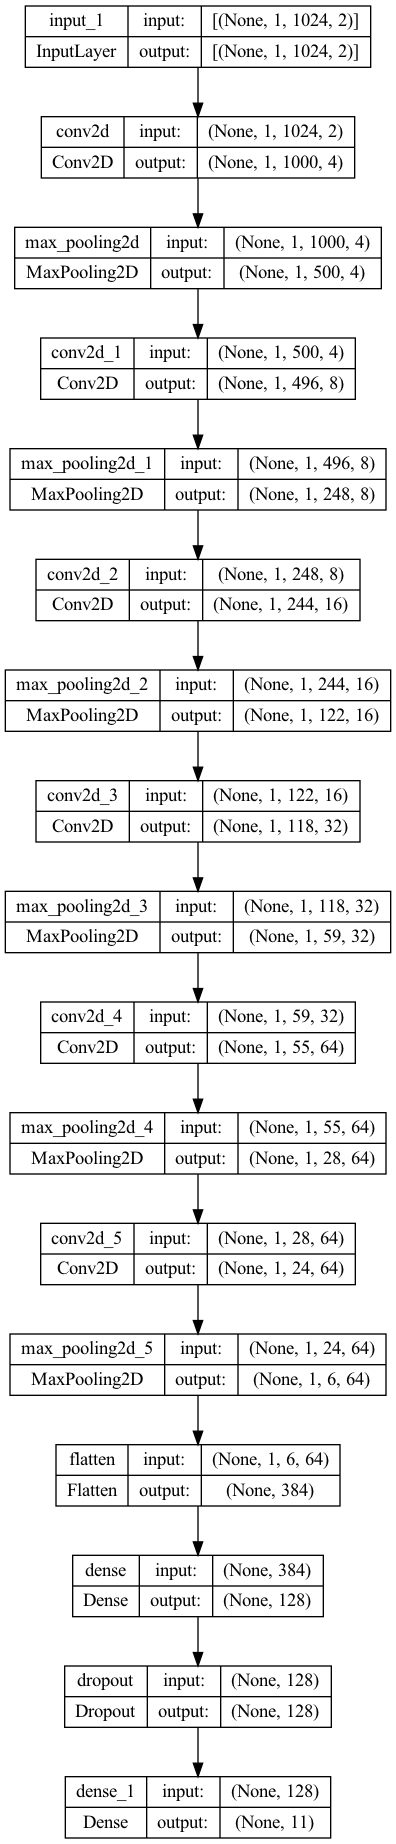

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='StandardCNN.png', show_shapes=True,show_layer_names=True)

## Bayesian CNN

Below I have created a Bayesian CNN. The architecture is the same as that of the Standard CNN except for 2 layers. The first Convolutional layer is now a Convolutional2DReparameterization layer. Instead of creating a discrete output as a standard CNN does, it will create an output that is drawn from a distribution. This layer displays aleatoric uncertainty, or uncertainty that arises from the data quality. The last layer is now a DenseReparameterization layer. The layer takes epistemic uncertainty into account. Epistemic uncertainty is the uncertainty that arises from the model itself. 

In [15]:
tfd = tfp.distributions
tfpl = tfp.layers

In [16]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/3457

model_bayes = Sequential([
    tf.keras.layers.InputLayer(input_shape=(1, 1024,2)),
    tfpl.Convolution2DReparameterization(filters=4, kernel_size=(1,25), activation='relu',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn),
    MaxPool2D(1,2),
    Conv2D(8,kernel_size=(1,5), activation='relu'),
    MaxPool2D(1,2),
    Conv2D(16,kernel_size=(1,5), activation='relu'),
    MaxPool2D(1,2),
    Conv2D(32,kernel_size=(1,5), activation='relu'),
    MaxPool2D(1,2),
    Conv2D(64, (1,5), activation='relu'),
    MaxPool2D(1,2),
    Conv2D(64, (1,5), activation='relu'),
    MaxPool2D(1,4),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(11), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn
                                ),
    tfpl.OneHotCategorical(11)
    
])
model_bayes.summary()

/Users/pauljojy/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/Users/pauljojy/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization (  (None, 1, 1000, 4)       408       
 Conv2DReparameterization)                                       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 1, 500, 4)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 496, 8)         168       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 1, 248, 8)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 244, 16)        656       
                                                      

## Compile Bayes Model

A negative log-likelihood is used as the loss function to maximize the likelihood estimate of the mean and the standard deviation of the weights.

In [17]:
def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_bayes.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.005),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

cp_callback = ModelCheckpoint(filepath =checkpoint_dir + '/BayesNet.h5', 
                              verbose = 1,
                              save_best_only=True, 
                              save_weights_only=True)
earlystopping_callback = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    mode='auto',
    verbose = 1)

In [18]:
if os.path.exists('checkpoints/BayesNet.h5'):
    model_bayes.load_weights('checkpoints/BayesNet.h5')
else:
    history_bayes = model_bayes.fit(X_train,
                                    Y_train,
                                    batch_size=batch_size,
                                    epochs=nb_epoch*3, #using more epochs because this model is more complex
                                    verbose=1,
                                    validation_data=(X_test, Y_test),
                                    validation_batch_size=batch_size,
                                    callbacks = cp_callback)

## Visualize Network Architecture

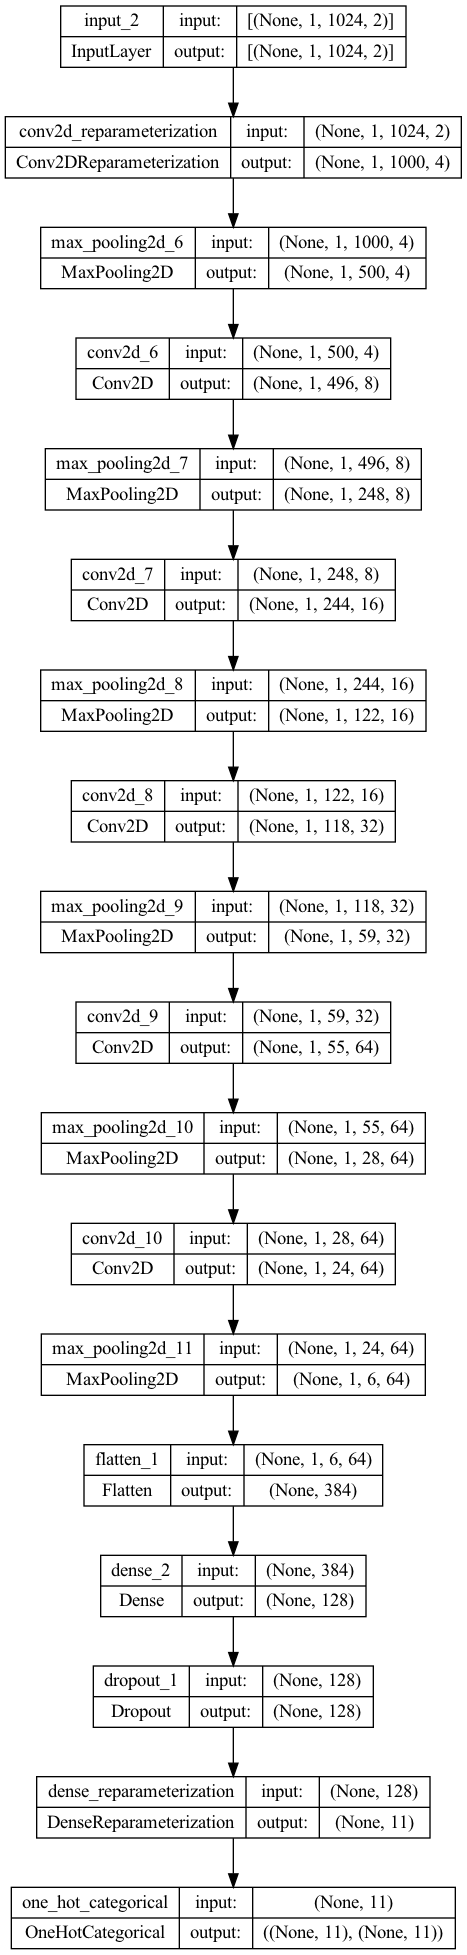

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model_bayes, to_file='Bayes.png', show_shapes=True,show_layer_names=True)

# 3. Analyze Results
Below I used 3 different methods to compare performance between the 2 models.
## Simple Accuracy Score

In [20]:
# Show simple version of performance
start = time.time()
CNN_score = model.evaluate(X_test, Y_test,  verbose=0, batch_size=batch_size)
end = time.time()
print(f'The accuracy for the Standard CNN is: {(CNN_score[1]*100):.{2}f}% and the time it takes to run (Latency) is {(end-start):.{4}f}s')
start = time.time()
bayes_score = model_bayes.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
end = time.time()
print(f'The accuracy for the Bayes model is: {(bayes_score[1]*100):.{2}f}% and the time it takes to run (Latency) is {(end-start):.{2}f}s')

The accuracy for the Standard CNN is: 60.70% and the time it takes to run (Latency) is 10.3981s
The accuracy for the Bayes model is: 52.21% and the time it takes to run (Latency) is 10.57s


When comparing accuracy of the 2 models on the same dataset, we see the Standard CNN slightly outperforms the Bayes net. The Standard CNN is slightly faster as well,perhaps because the Bayes Net architecture is slightly more complicated.



## Confusion Matrix
The below confusion matrices tell us how good one model is at measuring a certain class versus the other.

In [21]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize = (15,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    label_len = np.shape(labels)[0]
    tick_marks = np.arange(label_len)
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
def build_matrix(model):
    # Plot confusion matrix
    test_Y_hat = model.predict(X_test, batch_size=batch_size)
    conf = np.zeros([num_classes,num_classes])
    confnorm = np.zeros([num_classes,num_classes])
    for i in range(0,X_test.shape[0]):
        j = list(Y_test[i,:]).index(1)
        k = int(np.argmax(test_Y_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,num_classes):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plot_confusion_matrix(confnorm, labels=mods)

### Standard CNN Confusion Matrix

229/229 [==============================] - 13s 56ms/step


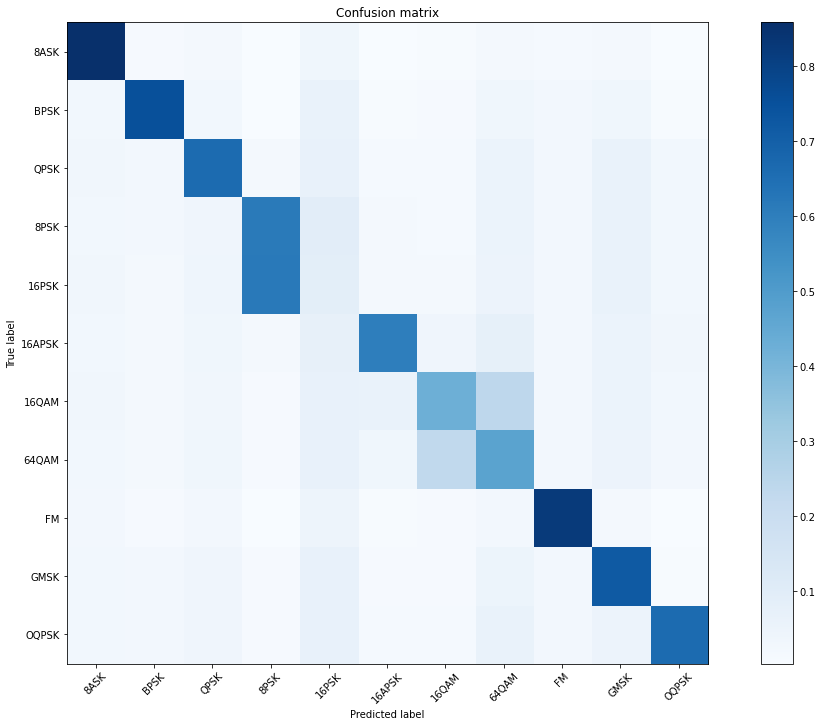

In [23]:
build_matrix(model)

The above graph shows us that the standard CNN is decently accurate at predicting the correct label of each class. It seems that the most difficult classification task for the standard CNN is identifying 16PSK.

229/229 [==============================] - 11s 45ms/step


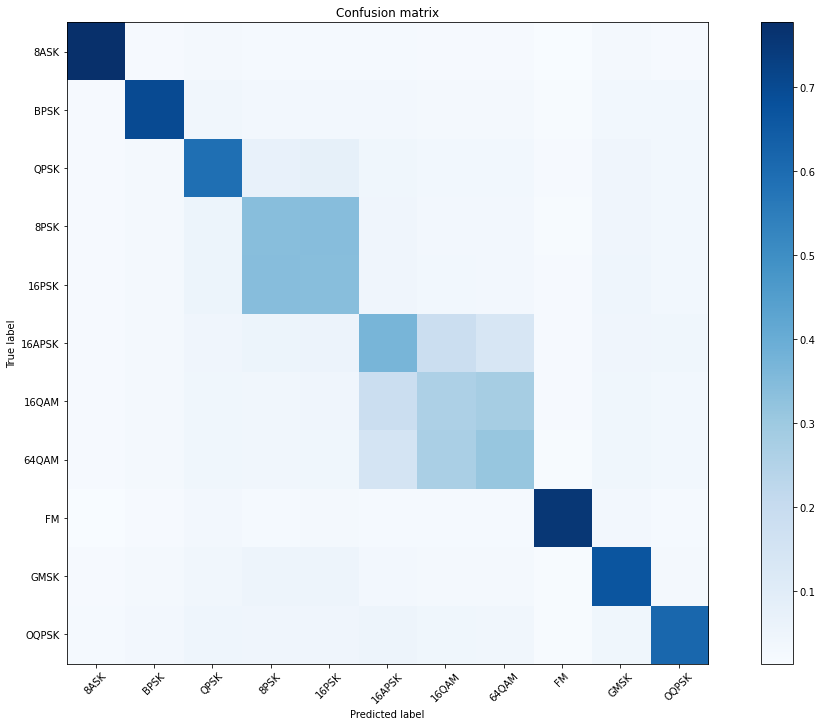

In [24]:
build_matrix(model_bayes)

### Bayesian CNN Confusion Matrix

The above graph shows that the Bayes net is able to predict some classes very well, like FM and 8ASK. However, like the Standard CNN, it also struggles with 16PSK. It also seems to not predict some classes as well as the baseline can, such as 64QAM or 16QAM.

## Generate Classification Report

### Standard CNN

In [25]:
def report(model):
    Y_pred = model.predict(X_test,batch_size=batch_size)
    y_pred = np.argmax(Y_pred, axis = 1)
    y_actual = np.argmax(Y_test, axis = 1)
    classificationreport_fp = classification_report(y_actual,y_pred, target_names=mods)
    print(classificationreport_fp)

In [26]:
report(model)

229/229 [==============================] - 11s 47ms/step
              precision    recall  f1-score   support

        8ASK       0.75      0.86      0.80     21128
        BPSK       0.78      0.75      0.77     21295
        QPSK       0.67      0.66      0.66     21182
        8PSK       0.46      0.61      0.53     21266
       16PSK       0.12      0.09      0.10     21451
      16APSK       0.76      0.60      0.67     21340
       16QAM       0.53      0.43      0.47     21330
       64QAM       0.42      0.47      0.44     21375
          FM       0.78      0.82      0.80     21463
        GMSK       0.61      0.72      0.66     21434
       OQPSK       0.77      0.66      0.71     21028

    accuracy                           0.61    234292
   macro avg       0.60      0.61      0.60    234292
weighted avg       0.60      0.61      0.60    234292



The Standard CNN has the highest precision for the FM and BPSK classes. It has the highest recall for 8ASK. 

### Bayes CNN

In [27]:
report(model_bayes)

229/229 [==============================] - 10s 44ms/step
              precision    recall  f1-score   support

        8ASK       0.79      0.78      0.78     21128
        BPSK       0.72      0.70      0.71     21295
        QPSK       0.58      0.59      0.59     21182
        8PSK       0.33      0.35      0.34     21266
       16PSK       0.32      0.35      0.33     21451
      16APSK       0.37      0.37      0.37     21340
       16QAM       0.27      0.26      0.27     21330
       64QAM       0.32      0.31      0.32     21375
          FM       0.80      0.75      0.78     21463
        GMSK       0.62      0.66      0.64     21434
       OQPSK       0.64      0.61      0.63     21028

    accuracy                           0.52    234292
   macro avg       0.53      0.52      0.52    234292
weighted avg       0.52      0.52      0.52    234292



The Bayes Net has the highest precision for FM and 8ASK classes. It has the highest recall for 8ASK.

The above 2 charts reiterate what was seen in the confusion matrices. It's interesting that both models are able to identify FM well.

## Accuracy Vs SNR

In [28]:
def plot_accuracy_snr(model, X_test, Y_test, Z_test):
    batchsize = 1024
    snrlist = np.unique(Z_test)
    acc_snr_arr = []

    # interate over SNRs
    for snr in snrlist:
        acc_arr = []
        i_SNR = np.where(Z_test==snr)
        X_SNR = X_test[i_SNR[0],:,:]
        Y_SNR = Y_test[i_SNR[0],:]
        X_SNR_len = np.shape(X_SNR)[0]
        total_batches = int(X_SNR_len/batchsize)
    
        for i in (range(0, total_batches)):
            x_batch, y_batch = X_SNR[i*batchsize:i*batchsize+batchsize], Y_SNR[i*batchsize:i*batchsize+batchsize]
        
            # model prediction
            pred = model.predict(x_batch, verbose = 0)
        
            #Pediction values are onehote, corresponding to indices representing different modulation types
            pred_ind = np.argmax(pred, axis=1)
            expected_ind = np.argmax(y_batch, axis=1)
            matches  = sum(np.equal(pred_ind, expected_ind))
            acc      = matches/batchsize
            acc_arr.append(acc)

        # Average the per-batch accuracy values
        accuracy = np.mean(acc_arr)
        acc_snr_arr.append(accuracy)
    
    plt.figure(figsize=(1,1))
    plt.show()
    fig= plt.figure(figsize=(10,8))
    plt.plot(snrlist, acc_snr_arr, 'bo-', label='accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('SNR')
    plt.title("Accuracy vs SNR")
    plt.legend()
    plt.axis([-22, 32, 0, 1.0])
    plt.grid()


### Standard CNN

<Figure size 72x72 with 0 Axes>

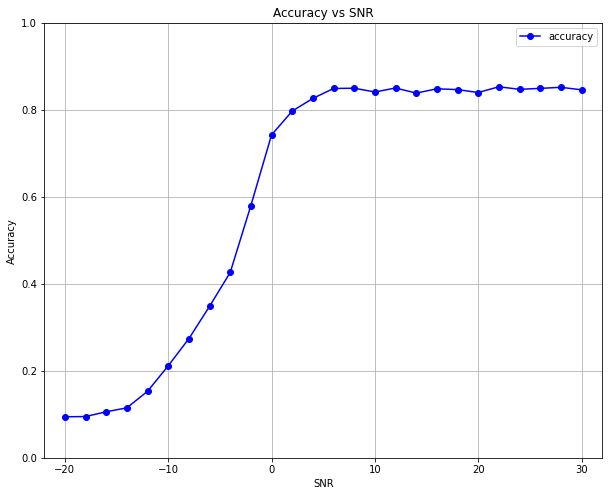

In [29]:
plot_accuracy_snr(model, X_test,Y_test,Z_test)

### Bayes CNN

<Figure size 72x72 with 0 Axes>

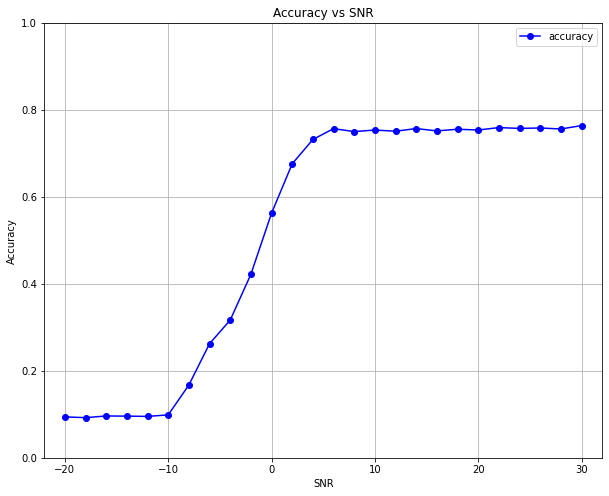

In [30]:
plot_accuracy_snr(model_bayes, X_test,Y_test,Z_test)

Comparing the above 2 plots, it seems that the Standard CNN is consistently better than the Bayes Net at varying SNR levels. At low SNRs, the performance is pretty similar. 

# 4. Advantage of a Bayes Net

Bayes allows us to unlock hidden information from a model that a standard CNN does not provide. It allows us to see how certain a model is when it makes a prediction. 

For the probabilistic model, I am not going to get the same probability value every time when predicting an image. The below function will run the image through the network 300 times, and create a 95% prediction interval for probabilities.

In [31]:
def predict_bayes(model_bayes, sample, true_label, labels):
    
    predicted_probabilities = np.empty(shape=(300, 11))

    for i in range(300):
        
        predicted_probabilities[i] = model_bayes(sample).mean().numpy()[0]
        
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(11)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(11)])
    ind = np.where(labels == true_label)
    fig, ax = plt.subplots(figsize=(12, 6))
    bar = ax.bar(np.arange(11), pct_97p5, color='red')
    bar[np.where(label == 1)[0][0]].set_color('green')
    bar = ax.bar(np.arange(11), pct_2p5-0.02, color='white')
    ax.set_xlabel('Class')
    ax.set_xticks(range(11))
    ax.set_xticklabels(labels)
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

Now we will test this function on a sample from the OQPSK class. The Standard CNN below predicts the image correctly, with almost 100% certainty. 

In [32]:
sample = myData[1171455:]
label = myMods[1171455:][0]
print(f'Label: {label}')
print(f'Sample shape: {np.shape(sample)}')
score = model(sample).numpy()[0]
pred = np.zeros(11)
pred[np.argmax(score)] = 1
print(f'Prediction Array: {score} \nThe prediction is {pred}')


Label: [0 0 0 0 0 0 0 0 0 0 1]
Sample shape: (1, 1, 1024, 2)
Prediction Array: [0.0000000e+00 6.5866481e-14 4.7371933e-11 1.5877697e-14 1.9805091e-14
 2.1423653e-13 5.8055227e-12 3.5235601e-15 0.0000000e+00 0.0000000e+00
 1.0000000e+00] 
The prediction is [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Now we will plot the confidence interval from the Bayes Net predictions on the same image. The Bayes Net also correctly identifies the class as 'OQPSK,' with almost absolute certainty.

/Users/pauljojy/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


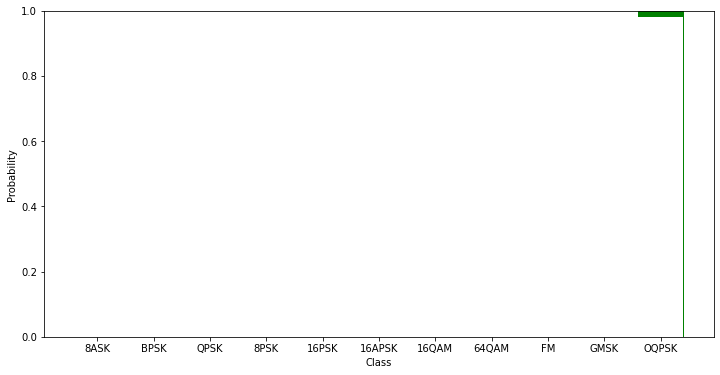

In [33]:
predict_bayes(model_bayes, sample,label,mods)

Now we will try a different image from the 'GMSK' class. Both models correctly predict the label, but the confidence intervals from the Bayes Net tell us that it is uncertain about the prediction. The aleatoric uncertainty is shown by the model assigning a high probability to the QPSK class. The epistemic uncertainty is shown by the model not sure of what probabilities to assign the other classes. 

Label: [0 0 0 0 0 0 0 0 0 1 0]
Sample shape: (1, 1, 1024, 2)
Prediction Array: [0.07394339 0.09755445 0.08887437 0.09820232 0.10385821 0.09478518
 0.0933199  0.10022009 0.03744062 0.12765287 0.08414866] 
The prediction is [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


/Users/pauljojy/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


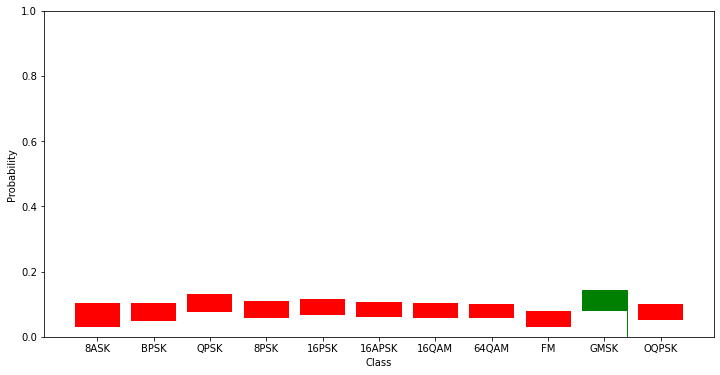

In [34]:
sample = myData[958465:958466]
label = myMods[958465:958466][0]
print(f'Label: {label}')
print(f'Sample shape: {np.shape(sample)}')
score = model(sample).numpy()[0]
pred = np.zeros(11)
pred[np.argmax(score)] = 1
print(f'Prediction Array: {score} \nThe prediction is {pred}')

predict_bayes(model_bayes, sample,label,mods)

# 5. Sources

https://towardsdatascience.com/creating-image-classification-model-with-bayesian-perspective-a90a5956b14e

https://github.com/Xilinx/Vitis-AI-Tutorials/blob/1.4/Design_Tutorials/10-RF_modulation_recognition/files/vai_2018_RadioML_VAI_keras.ipynb